# hydronetworks

In [1]:
# Import necessary modules

import geopandas as gpd
import pyproj
from pathlib import Path
import matplotlib.pyplot as plt
import rasterio
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
%matplotlib inline

## 1. Specify file paths & Projection system

In [2]:
in_path = Path('test_data')
out_path = Path('test_output')

admin_path = in_path / "pastaza.gpkg"
rivers_path = in_path / 'HydroRIVERS_10v.gpkg'
dem_path = in_path / 'cond_dem.tif'

## Not needed in this version of the code
flow_path = in_path                         # in_path / 'qmean.tif'
flowacc_path = in_path                      # in_path / 'accflow.tif'

# Define projection system as suitable per case
sel_proj = 'epsg:24877'   # PSAD56 / UTM zone 17S for Pastaza province, Ecuador

In [3]:
from hydronetworks import HydroNetworks

In [4]:
net = HydroNetworks(rivers_path=rivers_path,
                    dem_path=dem_path,
                    flow_path=flow_path,
                    flowacc_path=flowacc_path,
                    admin_path=admin_path,
                    sel_proj=sel_proj)

In [5]:
net.load_files()

In [6]:
net.river_selection(3.0)

River network selected based on Strahler order


In [7]:
#fig, ax = plt.subplots(figsize=(15, 15))
#net.admin.plot(ax=ax, edgecolor='brown', alpha=0.2)
#net.rivers.plot(ax=ax, color='green', edgecolor='none', figsize=(20, 20), alpha=0.8, label='HydroRIVERS')
#ax.set_aspect('equal', 'box')
#leg = ax.legend()
# 
## Save plot as figure 
##plt.savefig('xxx.png', bbox_inches='tight')

In [8]:
#print('DEM')
#
#fig, ax = plt.subplots(figsize=(10, 10))
#plt.imshow(net.dem.read(1), vmin=0, vmax=1000)
#ax.set_aspect('equal', 'box')
#plt.show()  
## Save plot as figure 
##plt.savefig('xxx.png', bbox_inches='tight')

In [9]:
net.calculate_hydro(interval=1000, head_distance=500, get_range=False)

Calculated hydro potential


In [10]:
net.result_processor()

Results processed!


In [20]:
#fig, ax = plt.subplots(figsize=(12, 12))
#net.mini_and_small_hydro.sort_values('power', ascending=True).plot(ax=ax, column='power', legend=True, label='M&S hydro points', 
#                                                                   edgecolor='none', figsize=(32,32), alpha=0.9)
#ax.set_aspect('equal', 'box')
#leg = ax.legend()
# 
## Save plot as figure 
##plt.savefig('xxx.png', bbox_inches='tight')
#txt = ax.set_title('Potential points fro small-scale hydropower potential in Pastaza, Ecuador')

## 2. Read in all the necessary files
And do some quick sanity checks

## 2. Process network and attributes
These will be the main data structures for holding the river network, and the nodes where rivers join

In [13]:
net.create_network()

Created network and nodes


Then calculate Shreve stream order for the network
This allows to easily keep track of what is upstream and downstream

In [14]:
#net.assign_streamorder()

And import elevation, gscd etc for each node

In [15]:
net.load_attributes()

Attributes loaded


Convert to GeoDataFrames

In [16]:
net.network_to_gdf()

Converted!


In [17]:
net.rivers_out.head(4)

,HYRIV_ID,NEXT_DOWN,MAIN_RIV,LENGTH_KM,DIST_DN_KM,DIST_UP_KM,CATCH_SKM,UPLAND_SKM,ENDORHEIC,DIS_AV_CMS,...,geometry,idx,xs,ys,xe,ye,node_start,node_end,so,length
0,60464935.0,60465262.0,60443230.0,1.77,4192.0,37.7,3.65,180.3,0.0,17.565,...,"MULTILINESTRING ((-77.08125 -1.01458, -77.0811...",0,936592,9887969,936608,9887984,0,1,-99,417
1,60464936.0,60465262.0,60443230.0,1.64,4192.2,2.7,2.79,2.8,0.0,0.255,...,"MULTILINESTRING ((-77.06776 -1.01557, -77.0729...",1,938097,9887858,937787,9888692,2,3,-99,1271
2,60465256.0,60465258.0,60443230.0,0.46,4205.3,24.4,0.64,141.2,0.0,13.835,...,"MULTILINESTRING ((-77.17452 -1.01875, -77.1729...",2,926191,9887520,926370,9887520,4,8,-99,178
3,60465257.0,60465258.0,60443230.0,0.69,4205.3,1.6,1.50,1.5,0.0,0.142,...,"MULTILINESTRING ((-77.17292 -1.01687, -77.1729...",3,926370,9887728,926370,9887520,6,8,-99,208


In [18]:
net.nodes_out.head(4)

,idx,x,y,elevation,runoff,flow_acc,arcs,geometry
0,0,936592,9887969,267,2382,268,[0],POINT (-77.08126 -1.01459)
1,1,936608,9887984,267,2382,268,[0],POINT (-77.08112 -1.01445)
2,2,938097,9887858,280,2382,3,[1],POINT (-77.06776 -1.01557)
3,3,937787,9888692,281,2382,270,[1],POINT (-77.07055 -1.00805)


In [19]:
net.calculate_hydro()

10000
Calculated hydro potential


In [13]:
net.calculate_hydro(interval=1000, head_distance=500, get_range=False)


10000
Calculated hydro potential


In [14]:
net.hydro_points.head(3)

,HYRIV_ID,elevation,flowrate,geometry,head,power
0,60464936.0,283,0.255,POINT (-77.06776 -1.01557),7,8742.904742
1,60464936.0,287,0.255,POINT (-77.07170 -1.00920),9,11240.877526
2,60465261.0,281,17.004,POINT (-77.08418 -1.01458),6,499712.108360


No handles with labels found to put in legend.


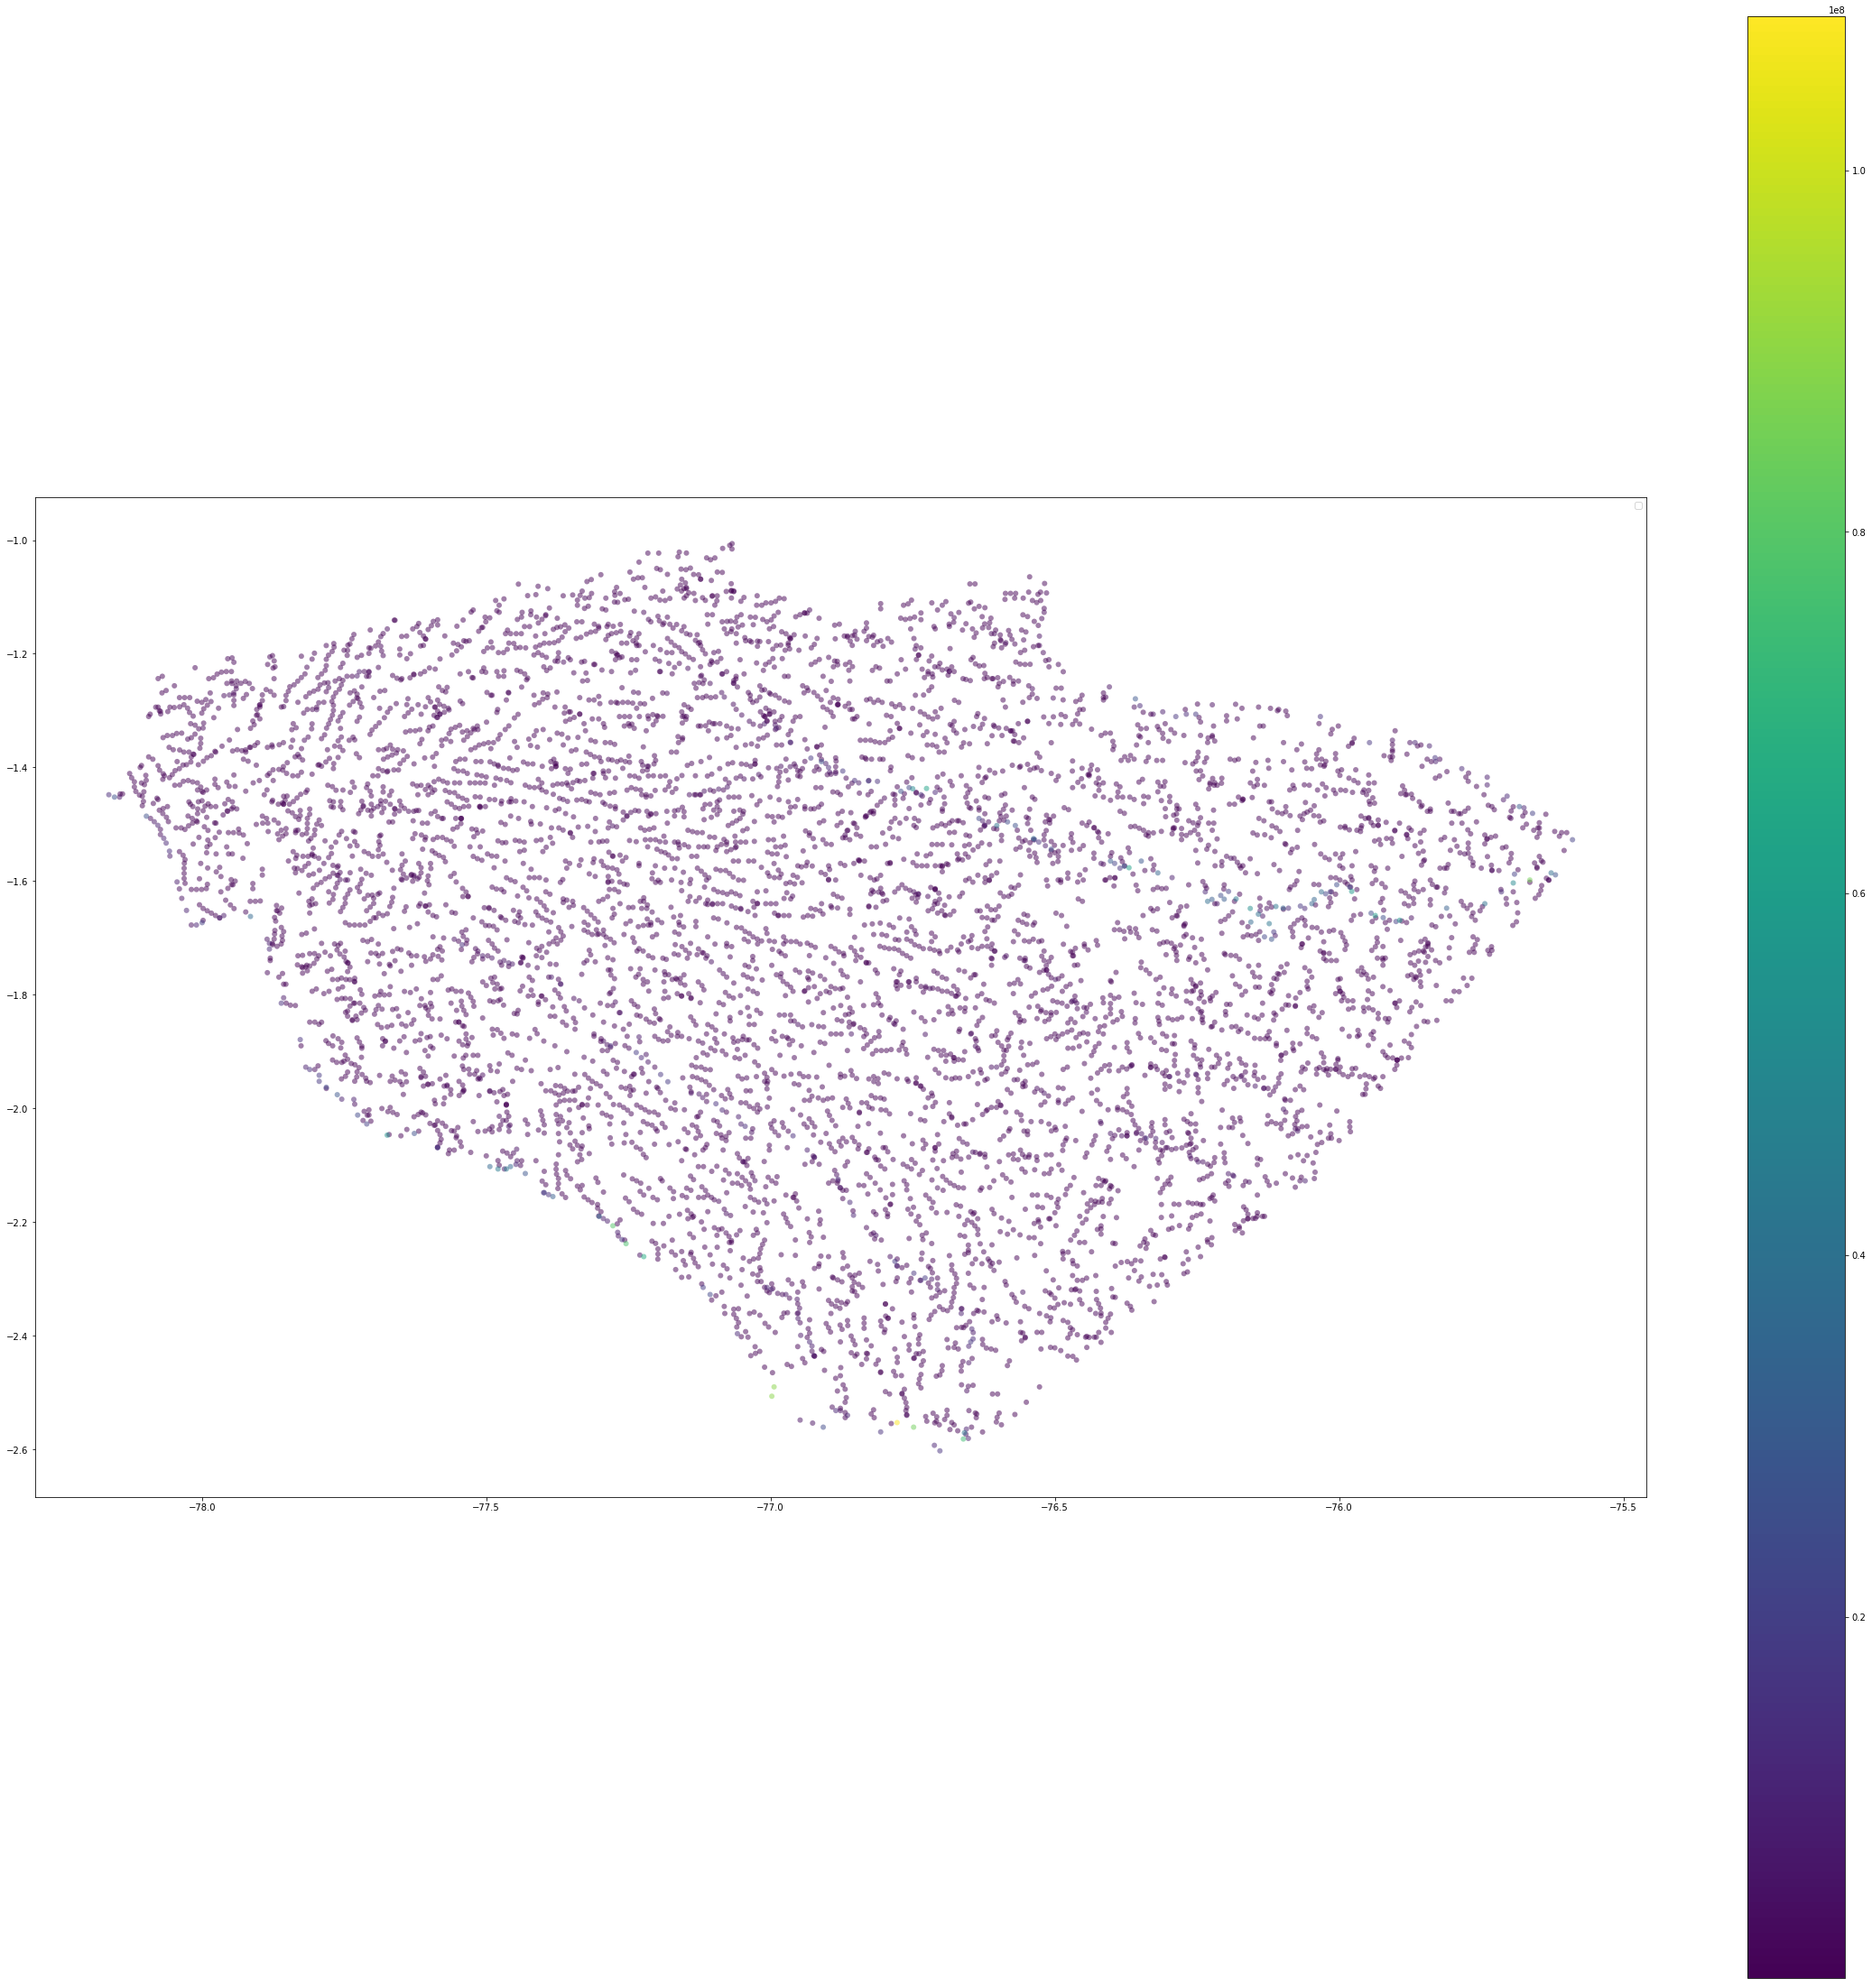

In [15]:
fig, ax = plt.subplots(figsize=(40, 40))
#admin_gdf_proj.plot(ax=ax, edgecolor='brown', alpha=0.2)
#net.hydro_points.plot(ax=ax, color='green', edgecolor='none', figsize=(20, 20), alpha=0.8, label='HydroRIVERS')
net.hydro_points.sort_values('power', ascending=True).plot(ax=ax, column='power', legend=True, edgecolor='none', figsize=(10, 10), alpha=0.5)
ax.set_aspect('equal', 'box')
leg = ax.legend()
 
# Save plot as figure 
#plt.savefig('xxx.png', bbox_inches='tight')

## 3. Calculate local flow and hydro potential

In [11]:
net.local_flowacc()
net.calculate_hydro()

Calculated hydro potential


## 4. Sanity check and save

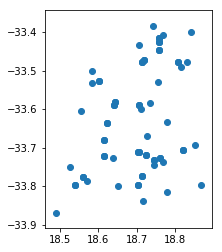

In [12]:
net.nodes_out.plot()

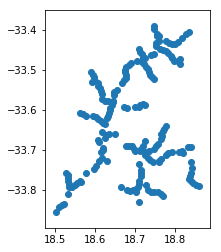

In [13]:
net.hydro_points.plot()

In [14]:
net.save_results(out_path)